In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot
from sklearn.metrics import plot_confusion_matrix

In [40]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [41]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


# Exploratory Data Analysis

In [43]:
## Check the Null Values 
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

We can see that there are some null value

In [44]:
# Now count the Unique values to check the data is balanced or not
count = np.unique(df['label'], return_counts=True)
count

(array([0, 1], dtype=int64), array([10387, 10413], dtype=int64))

In [45]:
#filling NULL values with empty string
df=df.fillna('')
test=test.fillna('')

<AxesSubplot:xlabel='label', ylabel='count'>

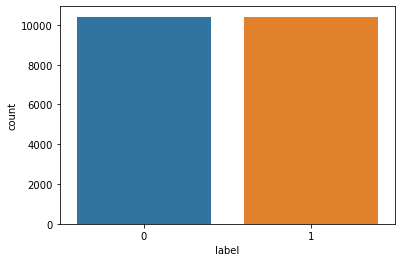

In [46]:
import seaborn as sns
sns.countplot(x='label', data = df)

We can see that this dataset is balanced so we don't have to do anything here

# Data Preprocessing & Cleaning

In [47]:
# We will be only using title and author name for prediction
# Creating new coolumn total concatenating title and author
df['total'] = df['title']+' '+df['author']
test['total']=test['title']+' '+test['author']

In [48]:
test.head()

,id,title,author,text,total
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...","Specter of Trump Loosens Tongues, if Not Purse..."
1,20801,Russian warships ready to strike terrorists ne...,,Russian warships ready to strike terrorists ne...,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,#NoDAPL: Native American Leaders Vow to Stay A...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...","Tim Tebow Will Attempt Another Comeback, This ..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,Keiser Report: Meme Wars (E995) Truth Broadcas...


In [49]:
X_train = df.drop('label',axis=1)
y_train=df['label']
print(X_train.shape)
print(y_train.shape)

(20800, 5)
(20800,)


In [50]:
X_train.head()

,id,title,author,text,total
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",Why the Truth Might Get You Fired Consortiumne...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,Iranian woman jailed for fictional unpublished...


In [51]:
y_train.head()

0    1
1    0
2    1
3    1
4    1
Name: label, dtype: int64

In [52]:
#Choosing vocabulary size to be 5000 and copying data to msg for further cleaning
voc_size = 5000
msg = X_train.copy()
msg_test = test.copy()

In [53]:
#Downloading stopwords 
#Stopwords are the words in any language which does not add much meaning to a sentence.
#They can safely be ignored without sacrificing the meaning of the sentence.
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Priyanka
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [54]:
#We will be using Stemming here
#Stemming map words to their root forms
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []

In [55]:
#Applying stemming and some preprocessing
for i in range(len(msg)):
  review = re.sub('[^a-zA-Z]',' ',msg['total'][i])
  review = review.lower()
  review = review.split()
  review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
  review = ' '.join(review)
  corpus.append(review)

In [56]:
#Applying stemming and some preprocessing for test data
corpus_test = []
for i in range(len(msg_test)):
  review = re.sub('[^a-zA-Z]',' ',msg_test['total'][i])
  review = review.lower()
  review = review.split()
  review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
  review = ' '.join(review)
  corpus_test.append(review)

In [57]:
# Converting to one hot representation
onehot_rep = [one_hot(words,voc_size)for words in corpus]
onehot_rep_test = [one_hot(words,voc_size)for words in corpus_test]

In [58]:
#Padding Sentences to make them of same size
embedded_docs = pad_sequences(onehot_rep,padding='pre',maxlen=25)
embedded_docs_test = pad_sequences(onehot_rep_test,padding='pre',maxlen=25)

# Model 

In [59]:
#We have used embedding layers with LSTM
model = Sequential()
model.add(Embedding(voc_size,40,input_length=25))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

In [60]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 25, 40)            200000    
                                                                 
 dropout_3 (Dropout)         (None, 25, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               56400     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                6464      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

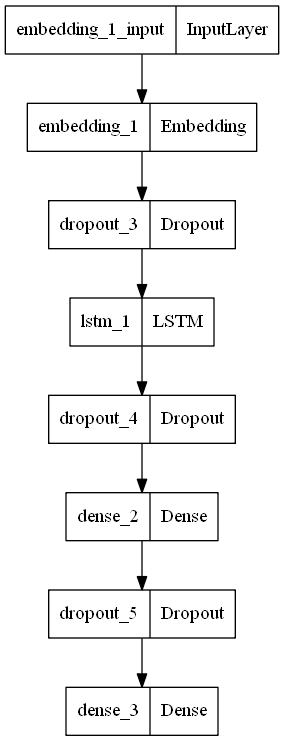

In [61]:
# plot graph
plot_model(model, to_file='fake_news.png')

In [62]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [63]:
#Converting into numpy array
X_final = np.array(embedded_docs)
y_final = np.array(y)
test_final = np.array(embedded_docs_test)
X_final.shape,y_final.shape,test_final.shape

((20800, 25), (20800,), (5200, 25))

# Model Fit

In [64]:
#training model
model.fit(X_final,y_final,epochs=10,batch_size=64)

Epoch 1/10
325/325 [==============================] - 4s 8ms/step - loss: 0.1533 - accuracy: 0.9317
Epoch 2/10
325/325 [==============================] - 3s 8ms/step - loss: 0.0214 - accuracy: 0.9942
Epoch 3/10
325/325 [==============================] - 3s 8ms/step - loss: 0.0105 - accuracy: 0.9973
Epoch 4/10
325/325 [==============================] - 2s 8ms/step - loss: 0.0051 - accuracy: 0.9985
Epoch 5/10
325/325 [==============================] - 2s 7ms/step - loss: 0.0044 - accuracy: 0.9987
Epoch 6/10
325/325 [==============================] - 2s 7ms/step - loss: 0.0042 - accuracy: 0.9985
Epoch 7/10
325/325 [==============================] - 2s 7ms/step - loss: 0.0023 - accuracy: 0.9995
Epoch 8/10
325/325 [==============================] - 2s 7ms/step - loss: 5.8066e-04 - accuracy: 0.9999
Epoch 9/10
325/325 [==============================] - 2s 7ms/step - loss: 0.0012 - accuracy: 0.9995
Epoch 10/10
325/325 [==============================] - 2s 7ms/step - loss: 0.0018 - accuracy: 0.

# Model Prediction

In [65]:
y_pred = model.predict(test_final)

163/163 [==============================] - 1s 2ms/step


In [66]:
print(y_pred)

[[6.7614909e-15]
 [1.0000000e+00]
 [9.9999583e-01]
 ...
 [4.2651749e-07]
 [9.9999893e-01]
 [1.0410698e-15]]


In [67]:
if (y_pred[i] > 0.5):
    Label = 1
else:
    Label = 0

In [68]:
# save the whole model
model.save("./fake_model.h5")

In [69]:
y_pred

array([[6.7614909e-15],
       [1.0000000e+00],
       [9.9999583e-01],
       ...,
       [4.2651749e-07],
       [9.9999893e-01],
       [1.0410698e-15]], dtype=float32)

In [70]:
y_pred=(y_pred>0.5)
y_pred

array([[False],
       [ True],
       [ True],
       ...,
       [False],
       [ True],
       [False]])